In [1]:
% matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [2]:
N = 500

transform = transforms.Compose(
    [transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

idx = range(N)
split = 0.7
train_idx = np.random.choice(idx, size=int(N*split), replace=False)
val_idx = list(set(idx) - set(train_idx))
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

image_dataset = torchvision.datasets.ImageFolder(root='./images', transform=transform)
train_loader = torch.utils.data.DataLoader(image_dataset, batch_size=32,
                                          num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(image_dataset, batch_size=32,
                                          num_workers=1, sampler=val_sampler)
dataloaders = {'train': train_loader, 'val': val_loader}

use_gpu = torch.cuda.is_available()

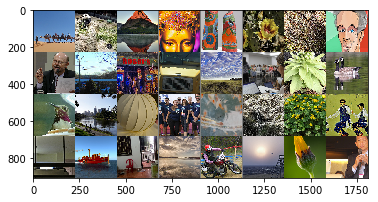

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
model_conv = models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
if use_gpu:
    model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)
# optimizer_conv = optim.Adam()

dataset_sizes = {'train': int(N*split), 'val': int(N*(1-split))}
class_names = image_dataset.classes

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    return model

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7906 Acc: 0.6600
val Loss: 0.6771 Acc: 0.7000
Epoch 1/4
----------
train Loss: 0.4626 Acc: 0.8000
val Loss: 0.5626 Acc: 0.8600
Epoch 2/4
----------
train Loss: 0.4445 Acc: 0.8571
val Loss: 0.5354 Acc: 0.8600
Epoch 3/4
----------
train Loss: 0.4215 Acc: 0.8657
val Loss: 0.5221 Acc: 0.8600
Epoch 4/4
----------
train Loss: 0.4320 Acc: 0.8600
val Loss: 0.5236 Acc: 0.8600
Training complete in 5m 2s


In [ ]:
torch.save(model_conv, 'cnn_model.pt')